In [1]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd',
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
import lfp_synchrony
from eeg_plotting import plot_trace, plot_trace2

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


In [2]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import gc
import random

In [3]:
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c]]
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)

In [4]:
sampling_rate = 500
freqs = np.logspace(np.log10(0.5), np.log10(128), 17)
rois = ['hpc', 'amy', 'ec', 'phg', 'ctx']

In [5]:
# Get session info.
subj_df = phase_locking.get_subj_df()
subj_df.insert(4, 'chan_ind', subj_df.chan.apply(lambda x: int(x)-1))

In [6]:
sessions1 = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
             'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2',
             'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
             'U371_env2', 'U371_env3']

sessions2 = [sub for sub in subj_df.subj_sess.unique().tolist() 
             if sub not in (sessions1 + ['U367_env2', 'U386_ses1', 'U386_ses2'])]
sessions_all = sessions1 + sessions2

print('sessions1: {} \nsessions2: {} \nsessions_all: {} \nsessions_available: {}'
      .format(len(sessions1), len(sessions2), len(sessions_all), len(subj_df.subj_sess.unique())))

sessions1: 14 
sessions2: 29 
sessions_all: 43 
sessions_available: 46


In [7]:
# Load the unit-to-region dataframe.
u2r_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/metadata',
                             '*_unit_to_lfp-region_pairs_df.pkl'))
print('Found {} files'.format(len(u2r_files)))

u2r_df = dio.open_pickle(u2r_files[0])
for f in u2r_files[1:]:
    u2r_df = u2r_df.append(dio.open_pickle(f))
u2r_df.reset_index(drop=True, inplace=True)

print(u2r_df.shape)

Found 44 files
(13658, 26)


In [18]:
np.sort(sessions_all)

array(['U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2',
       'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2',
       'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a',
       'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3',
       'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2',
       'U385_ses3', 'U385_ses4', 'U387_ses1', 'U387_ses2', 'U387_ses3',
       'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1',
       'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2',
       'U395_ses3', 'U396_ses2', 'U396_ses3'], dtype='<U10')

In [57]:
# Load phase-locking stats.
start_time = time()

pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_bband'
fname = 'phase_locking_stats-{}-unit_{}-lfp_{}-{}Hz-notch60_120Hz-nospikeinterp-5cycles-17log10freqs_0.5_to_128.0Hz.pkl'
complete_count = 0
incomplete_inds = []
first_row = True
for index, row in u2r_df.query("(subj_sess=={})".format(['U380_ses2'])).iterrows():
    fpath = os.path.join(pl_dir, fname.format(row.subj_sess, row.unit, row.lfp_hemroi, sampling_rate))
    if os.path.exists(fpath):
        complete_count += 1
        if first_row:
            pl_df = pd.DataFrame(dio.open_pickle(fpath)).T
            first_row = False
        else:
            pl_df = pl_df.append(dio.open_pickle(fpath))
    else:
        incomplete_inds.append(index)
pl_df.reset_index(drop=True, inplace=True)
print('pl_df: {}'.format(pl_df.shape))
print('{}/{} files not found\n'.format(len(incomplete_inds), complete_count+len(incomplete_inds)))

print('Done in {:.2f} secs'.format(time() - start_time))

pl_df: (520, 52)
0/520 files not found

Done in 41.60 secs


In [12]:
# Save phase-locking stats as a single DataFrame
dio.save_pickle(pl_df, os.path.join(pl_dir, 'all_phase_locking_stats-{}_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-17log10freqs_0.5_to_128.0Hz.pkl'.format(len(pl_df))))

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_bband/all_phase_locking_stats-13186_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-17log10freqs_0.5_to_128.0Hz.pkl


In [61]:
# Load phase-locking stats as a single DataFrame
pl_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/phase_locking/unit_to_region_bband'
pl_df = dio.open_pickle(os.path.join(pl_dir, 'all_phase_locking_stats-13186_unit_to_region_pairs-500Hz-notch60_120Hz-nospikeinterp-5cycles-17log10freqs_0.5_to_128.0Hz.pkl'))

In [62]:
map_dtypes = {'unit_nspikes': np.uint32,
              'unit_fr': np.float64,
              'lfp_is_hpc': np.bool,
              'same_chan': np.bool,
              'same_hemroi': np.bool,
              'same_hem': np.bool,
              'same_roi': np.bool,
              'both_hpc': np.bool,
              'same_roi2': np.bool,
              'locked_freq_ind': np.uint8,
              'locked_mrl': np.float64,
              'bs_ind': np.uint16,
              'bs_pval': np.float64,
              'sig': np.bool,
              'tl_locked_time_ind': np.uint16,
              'tl_locked_time': np.float64,
              'tl_locked_time_mrl': np.float64,
              'locked_freq_ind_z': np.uint8,
              'locked_mrl_z': np.float64,
              'bs_ind_z': np.uint16,
              'bs_pval_z': np.float64,
              'sig_z': np.bool,
              'tl_locked_time_ind_z': np.uint16,
              'tl_locked_time_z': np.float64,
              'tl_locked_time_mrl_z': np.float64}
for col, dtype in map_dtypes.items():
    pl_df[col] = pl_df[col].astype(dtype)

In [72]:
pl_df.query("(subj_sess=='U395_ses2') & (edge=='ctx-local') & (locked_freq_ind_z==16)").shape

(14, 52)

In [75]:
pl_df.query("(edge=='ctx-hpc') & (locked_freq_ind_z<15)").groupby('subj_sess').sig_z.mean()

subj_sess
U369_env1     0.276596
U369_env2     0.196429
U370_env1     0.347826
U371_env1     0.487805
U371_env2     0.510870
U371_env3     0.302158
U372_ses1     0.450000
U372_ses2     0.352941
U373_ses1     0.200000
U373_ses2     0.312500
U373_ses3     0.180000
U374_ses1     0.076923
U374_ses2     0.088235
U379_ses1     0.076190
U380_ses1a    0.186275
U380_ses2     0.237113
U380_ses3     0.253521
U381_ses1     0.311688
U381_ses2     0.397727
U381_ses3     0.349057
U384_ses1     0.236559
U384_ses2     0.252874
U384_ses3     0.150000
U385_ses1     0.483333
U385_ses2     0.285714
U385_ses3     0.276596
U385_ses4     0.265306
U387_ses1     0.575758
U387_ses2     0.678571
U387_ses3     0.714286
U390_ses1     0.000000
U390_ses2     0.166667
U390_ses3     0.545455
U390_ses4     0.066667
U392_ses1     0.272727
U393_ses2     0.333333
U394_ses1     0.288462
U394_ses3     0.076923
U395_ses1     0.500000
U395_ses2     0.666667
U395_ses3     0.344828
U396_ses2     0.571429
U396_ses3     0.481481
N

In [65]:
pl_df.query("(edge=='ctx-hpc') & (locked_freq_ind_z==16)").groupby('subj_sess').size()

subj_sess
U369_env1      6
U369_env2      6
U371_env1      2
U371_env3      1
U372_ses1     15
U372_ses2      1
U373_ses1      5
U373_ses2      2
U373_ses3      1
U374_ses2      2
U379_ses1     10
U380_ses1a     7
U380_ses2      4
U380_ses3      2
U381_ses1      2
U381_ses2      5
U381_ses3      5
U384_ses1      2
U384_ses2      1
U384_ses3      3
U385_ses1      2
U385_ses3      1
U385_ses4      1
U387_ses1      1
U393_ses2      2
U394_ses1      4
U394_ses3     15
U395_ses2     31
dtype: int64

In [21]:
# FDR correction
# Tests for phase-locking at any frequency:
# 1) For each connection, the maximum observed Z-score (across frequencies) is compared
#    against the surrogate distribution of maximum Z-scores; this gives an initial P-value
# 2) P-values for all connections for a given edge type are corrected to set 
#    a 5% false discovery rate
def bootstrap_p(x):
    """Return a p-value.
    
    For each connection, the maximum observed Z-score (across frequencies) 
    is compared against the surrogate distribution of maximum Z-scores.
    """
    obs = x.mrls_z # n_freq vec
    null = x.bs_mrls_z # n_freq x n_boot vec
    max_obs = np.max(obs)
    max_null = np.max(null, axis=0)
    n_bootstraps = len(max_null)
    pval = (1 + np.sum(max_null >= max_obs)) / (1 + n_bootstraps)
    return pval

pl_df['bs_mrls_z'] = pl_df.bs_mrls.apply(lambda x: stats.zscore(x, axis=-1))
pl_df['sig_z_fdr'] = False

for edge_type in ['ctx-local', 'ctx-ctx', 'hpc-local', 'hpc-hpc', 'hpc-ctx', 'ctx-hpc']:
    pvals_in = np.array(pl_df.loc[(pl_df.edge==edge_type)].apply(lambda x: bootstrap_p(x), axis=1).tolist())
    output = sm.stats.multipletests(pvals_in, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)
    sig_out = list(output[0])
    pvals_out = output[1]
    pl_df.loc[(pl_df.edge==edge_type), 'sig_z_fdr'] = sig_out

In [22]:
# On the fly Dice coefficient
((2 * np.sum(np.array(pl_df.sig_z.tolist()) * np.array(pl_df.sig_z_fdr.tolist())))
 / (np.sum(pl_df.sig_z) + np.sum(pl_df.sig_z_fdr)))

0.8269230769230769

## Analyze phase-locking results

In [24]:
pl_df.query("(subj_sess=='U369_env1') & (edge=='ctx-local')").shape

(51, 54)

In [25]:
pl_df.query("(subj_sess=='U369_env1') & (edge=='ctx-local')").groupby('locked_freq_ind_z').agg({'unit': len, 'sig_z_fdr': np.mean})

,unit,sig_z_fdr
locked_freq_ind_z,,
0,1,0.000000
1,1,1.000000
6,1,1.000000
7,4,1.000000
8,6,0.666667
10,1,1.000000
13,3,1.000000
14,6,0.833333
15,5,1.000000


In [26]:
cols = ['subj_sess_unit', 'lfp_hemroi', 'locked_freq_ind_z', 'locked_mrl_z', 'sig_z_fdr']
pl_df.query("(subj_sess=='U369_env1') & (edge=='ctx-local')")[cols].sort_values('locked_mrl_z', ascending=False)

,subj_sess_unit,lfp_hemroi,locked_freq_ind_z,locked_mrl_z,sig_z_fdr
87,U369_env1_20,RST,16,54.142700,True
31,U369_env1_14,RST,8,53.491963,True
55,U369_env1_17,RST,16,43.547036,True
119,U369_env1_24,RST,16,39.711841,True
111,U369_env1_23,RST,16,36.788548,True
63,U369_env1_18,RST,7,36.102344,True
12,U369_env1_1,RA,16,29.954658,True
71,U369_env1_19,RST,7,27.495893,True
198,U369_env1_33,RPS,16,25.830415,True
39,U369_env1_15,RST,16,24.872247,True


In [19]:
pl_df.groupby(['same_hem', 'edge']).agg({'unit': len, 'sig_z_fdr': np.mean})

unit  sig_z_fdr
same_hem edge                      
False    ctx-ctx    3319   0.089485
         ctx-hpc    1240   0.180645
         hpc-ctx     876   0.138128
         hpc-hpc     322   0.385093
True     ctx-ctx    3368   0.133610
         ctx-hpc    1367   0.300658
         ctx-local  1348   0.919139
         hpc-ctx     961   0.296566
         hpc-hpc      57   0.578947
         hpc-local   328   0.969512

In [23]:
(pl_df.query("(edge=='ctx-hpc') & (same_hem==True)").groupby(['unit_roi2'])
 .agg({'unit': len, 'sig_z': [np.sum, np.mean], 'sig_z_fdr': [np.sum, np.mean]}).reset_index())

unit_roi2 unit  sig_z           sig_z_fdr          
             len    sum      mean       sum      mean
0        ac  101   11.0  0.108911       2.0  0.019802
1       amy  378  208.0  0.550265     186.0  0.492063
2       ctx  281   73.0  0.259786      49.0  0.174377
3        ec  252  140.0  0.555556     120.0  0.476190
4       ofc  162   27.0  0.166667      19.0  0.117284
5       phg  193   41.0  0.212435      35.0  0.181347

In [22]:
pl_df.loc[pl_df.edge=='ctx-hpc'].groupby(['same_hem', 'unit_roi2']).agg({'unit': len, 'sig_z_fdr': np.mean})

unit  sig_z_fdr
same_hem unit_roi2                 
False    ac          104   0.048077
         amy         353   0.303116
         ctx         270   0.092593
         ec          220   0.159091
         ofc         168   0.101190
         phg         125   0.280000
True     ac          101   0.019802
         amy         378   0.492063
         ctx         281   0.174377
         ec          252   0.476190
         ofc         162   0.117284
         phg         193   0.181347

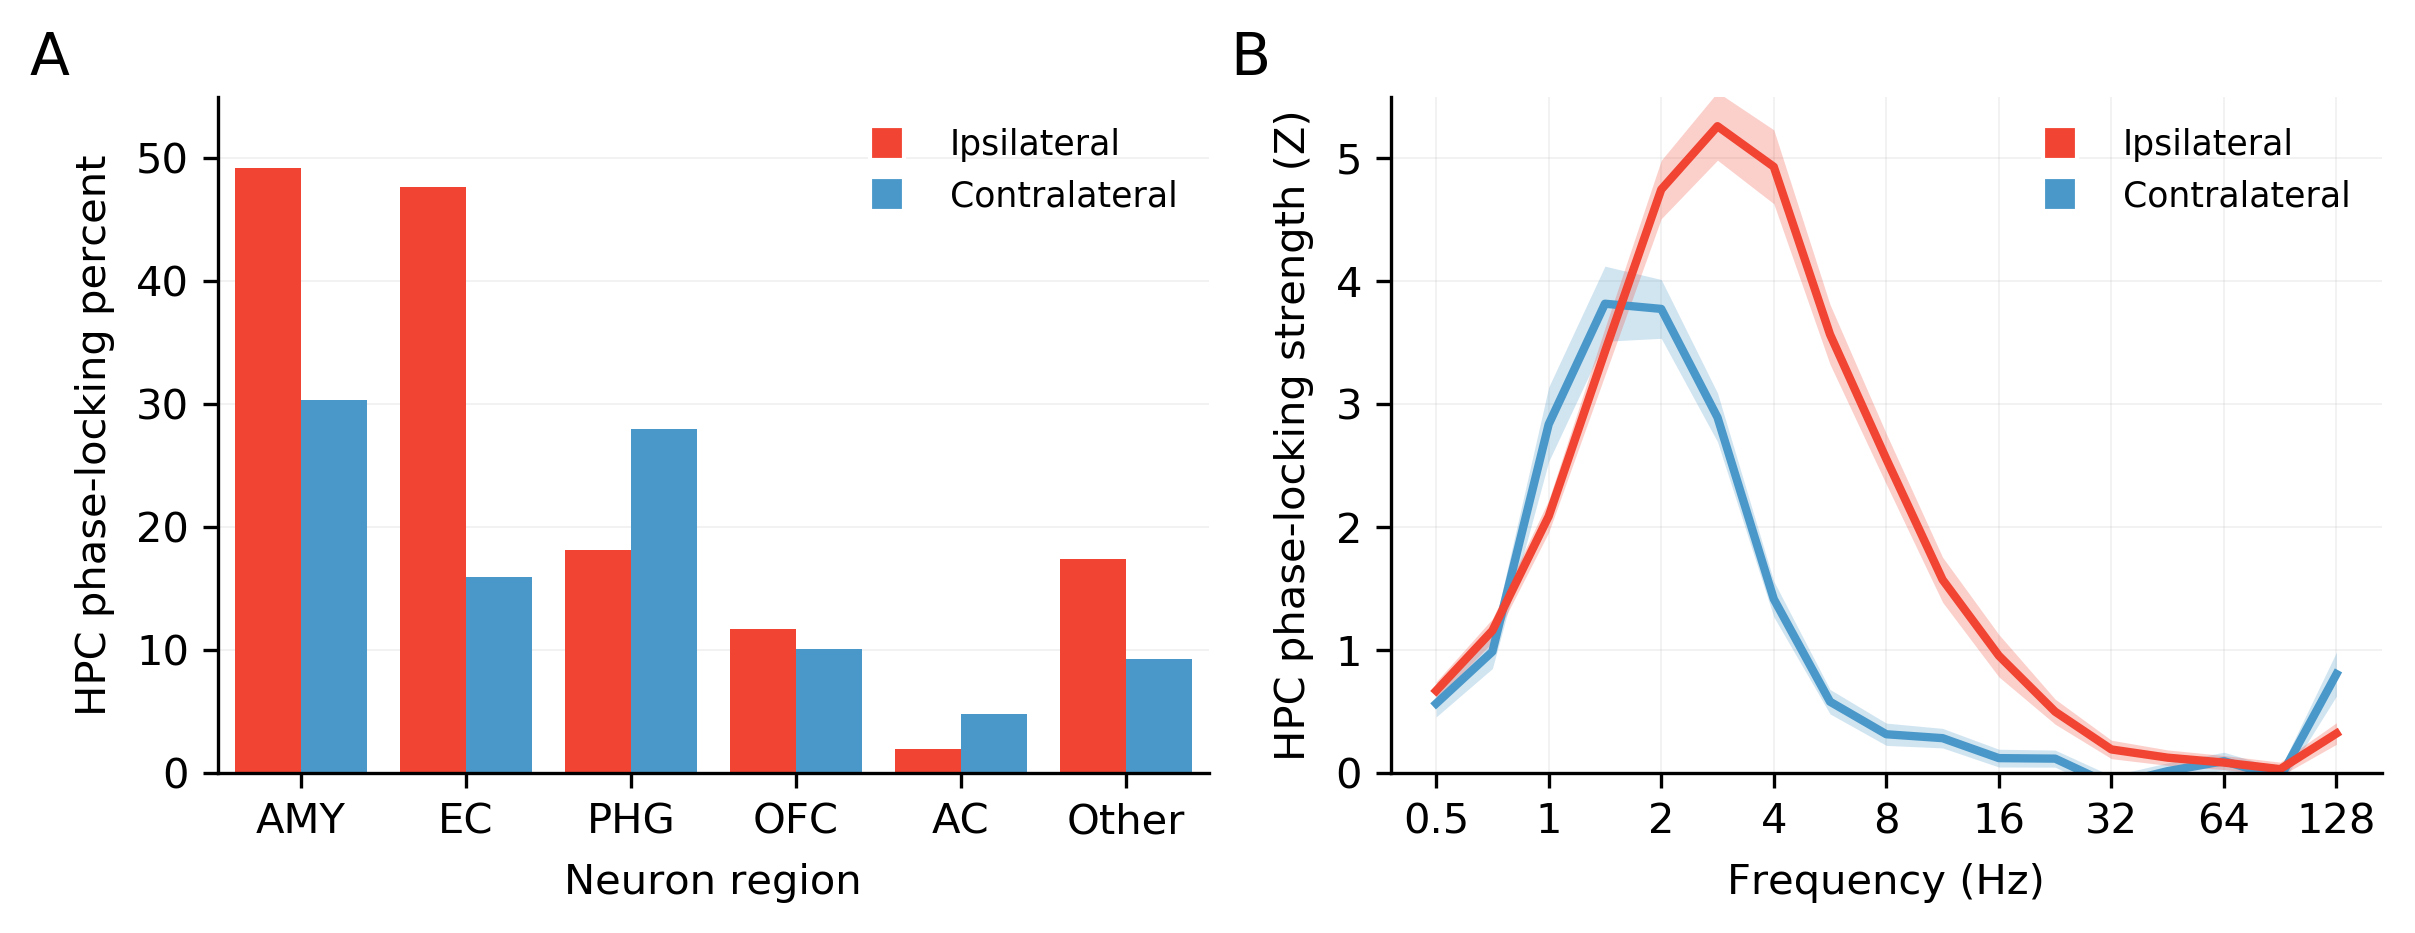

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
ax = np.ravel(ax)

tickfontsize = 10
labelfontsize = 10
figfontsize = 14

df = pl_df.query("(edge=='ctx-hpc')").groupby(['unit_roi2', 'same_hem']).agg({'unit': len, 'sig_z_fdr': np.mean}).reset_index()
rois = OrderedDict([('amy', 'AMY'),
                    ('ec', 'EC'), 
                    ('phg', 'PHG'),
                    ('ofc', 'OFC'),
                    ('ac', 'AC'),
                    ('ctx', 'Other')])
df['unit_roi2'] = df.unit_roi2.astype('category').cat.reorder_categories(rois.keys(), ordered=True)
df['hem'] = df.same_hem.apply(lambda x: 'ipsi' if x else 'contra')
df['hem'] = df.hem.astype('category').cat.reorder_categories(['ipsi', 'contra'], ordered=True)

i = 0
sns.barplot(x='unit_roi2', y='sig_z_fdr', hue='hem', data=df, 
            palette=[colors[1], colors[0]], saturation=1, ax=ax[i])
ax[i].set_xticklabels(rois.values(), fontsize=tickfontsize)
ax[i].set_ylim([0, 0.55])
ax[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax[i].set_yticklabels([0, 10, 20, 30, 40, 50], fontsize=tickfontsize)
ax[i].set_xlabel('Neuron region', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking percent', fontsize=labelfontsize, labelpad=5)
ax[i].get_legend().remove()

i = 1
mrls = {'ipsi': pl_df.query("(edge=='ctx-hpc') & (same_hem==True) & (sig_z_fdr==True)").mrls_z.tolist(),
        'contra': pl_df.query("(edge=='ctx-hpc') & (same_hem==False) & (sig_z_fdr==True)").mrls_z.tolist()}
means = {'ipsi': np.mean(mrls['ipsi'], axis=0),
         'contra': np.mean(mrls['contra'], axis=0)}
sems = {'ipsi': stats.sem(mrls['ipsi'], axis=0),
        'contra': stats.sem(mrls['contra'], axis=0)}
ax[i].fill_between(np.arange(len(freqs)), means['contra'] - sems['contra'], means['contra'] + sems['contra'], 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[i].fill_between(np.arange(len(freqs)), means['ipsi'] - sems['ipsi'], means['ipsi'] + sems['ipsi'], 
                   color=colors[1], alpha=0.25, linewidth=0)
ax[i].plot(np.arange(len(freqs)), means['contra'], color=colors[0], linewidth=2)
ax[i].plot(np.arange(len(freqs)), means['ipsi'], color=colors[1], linewidth=2)
ax[i].set_xticks(np.arange(len(freqs))[::2])
ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
ax[i].set_ylim([0, 5.5])
ax[i].set_yticks([0, 1, 2, 3, 4, 5])
ax[i].set_yticklabels([0, 1, 2, 3, 4, 5], fontsize=tickfontsize)
ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Ipsilateral', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Contralateral', markerfacecolor=colors[0], markersize=8)]
legend = ax[0].legend(handles=custom_lines, loc=1)
legend = ax[1].legend(handles=custom_lines, loc=1)

fig.text(0, 0.97, 'A', fontsize=figfontsize)
fig.text(0.5, 0.97, 'B', fontsize=figfontsize)
fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])
#plt.savefig('/scratch/dscho/unit_activity_and_hpc_theta/figs/PhaseLocking2.eps', format='eps', dpi=300, bbox_inches='tight')

In [82]:
np.unique(pl_df.query("(edge=='ctx-hpc') & (sig_z==True) & (locked_freq_ind_z==16)").unit_hemroi2, return_counts=True)

(array(['lac', 'lamy', 'lctx', 'lec', 'lphg', 'rac', 'ramy', 'rctx', 'rec',
        'rofc', 'rphg'], dtype=object),
 array([ 1,  8,  6,  1,  8,  1, 13,  1,  6,  1, 16]))

In [34]:
plt.plot(np.mean(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True) & (same_hem==True)").mrls_z.tolist(), axis=0), linewidth=2)
plt.plot(np.mean(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True) & (same_hem==False)").mrls_z.tolist(), axis=0), linewidth=2)

array([  0.5,   1. ,   2. ,   4. ,   8. ,  16. ,  32. ,  64. , 128. ])

In [52]:
print(np.unique(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True)").locked_freq_ind_z, return_counts=True))
print(np.unique(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True)").locked_freq_ind_z, return_counts=True))
print(np.unique(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)").locked_freq_ind_z, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([  7,  14,  28,  29,  41,  66,  76,  63,  50,  31,  26,  30,  32,
        32,  48,  85, 581]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8), array([  7,  13,  96,  85,  85, 111,  92,  50,  41,  20,   6,   7,   3,
         1,   4,   2, 124]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16],
      dtype=uint8), array([  7,  15,  45,  85, 144, 112,  88,  27,  32,   9,  13,   1,   3,
         1,   3,  50]))


In [86]:
print(pl_df.query("(edge=='ctx-local') & (subj_sess_unit!={})".format(bad_units)).sig_z_fdr.mean())
print(pl_df.query("(edge=='ctx-ctx') & (subj_sess_unit!={})".format(bad_units)).sig_z_fdr.mean())
print(pl_df.query("(edge=='ctx-hpc') & (subj_sess_unit!={})".format(bad_units)).sig_z_fdr.mean())

0.8401759530791789
0.13702710753649092
0.28433556050482556


In [84]:
print(pl_df.query("(edge=='ctx-local') & (locked_freq_ind_z<=14)").sig_z_fdr.mean())
print(pl_df.query("(edge=='ctx-ctx') & (locked_freq_ind_z<=14)").sig_z_fdr.mean())
print(pl_df.query("(edge=='ctx-hpc') & (locked_freq_ind_z<=14)").sig_z_fdr.mean())

0.8815384615384615
0.10466880161806844
0.24331103678929766


In [53]:
print(len(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True) & (locked_freq_ind_z==16)"))/len(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True)")))
print(len(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True) & (locked_freq_ind_z==16)"))/len(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True)")))
print(len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (locked_freq_ind_z==16)"))/len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)")))

0.4689265536723164
0.16599732262382866
0.07874015748031496


In [78]:
print(len(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True) & (locked_freq_ind_z>14)"))/len(pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True)")))
print(len(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True) & (locked_freq_ind_z>14)"))/len(pl_df.query("(edge=='ctx-ctx') & (sig_z_fdr==True)")))
print(len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True) & (locked_freq_ind_z>14)"))/len(pl_df.query("(edge=='ctx-hpc') & (sig_z_fdr==True)")))

0.5375302663438256
0.1686746987951807
0.08346456692913386


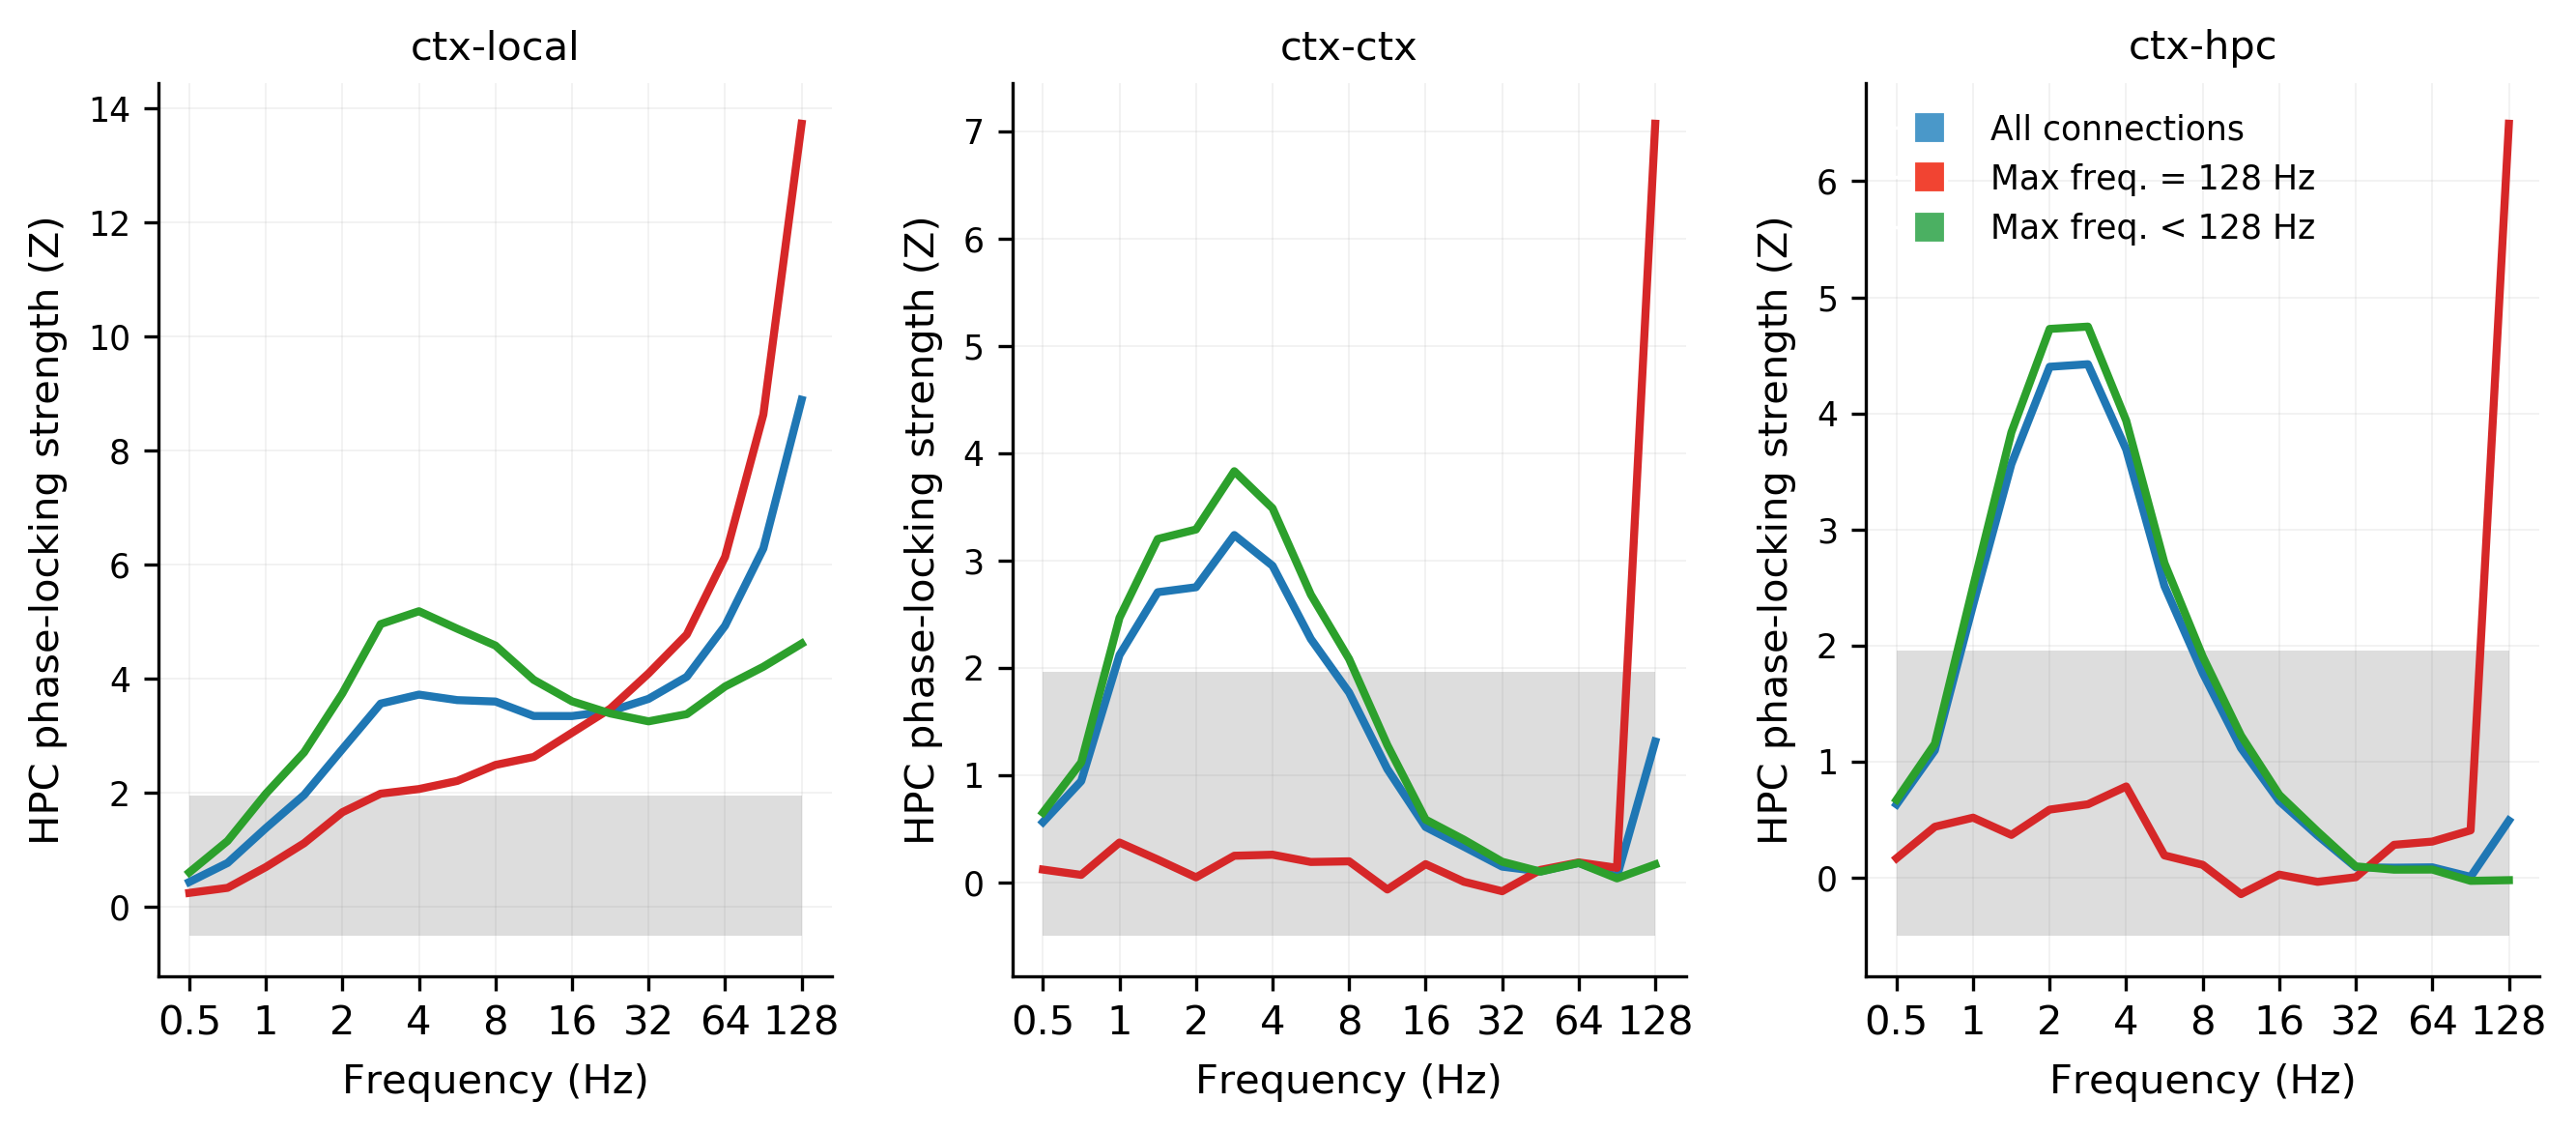

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
for i, edge_type in enumerate(['ctx-local', 'ctx-ctx', 'ctx-hpc']):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z==16)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z<16)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='All connections', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Max freq. = 128 Hz', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Max freq. < 128 Hz', markerfacecolor=colors[2], markersize=8)]
legend = ax[2].legend(handles=custom_lines, loc=2)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

In [ ]:
pl_df.

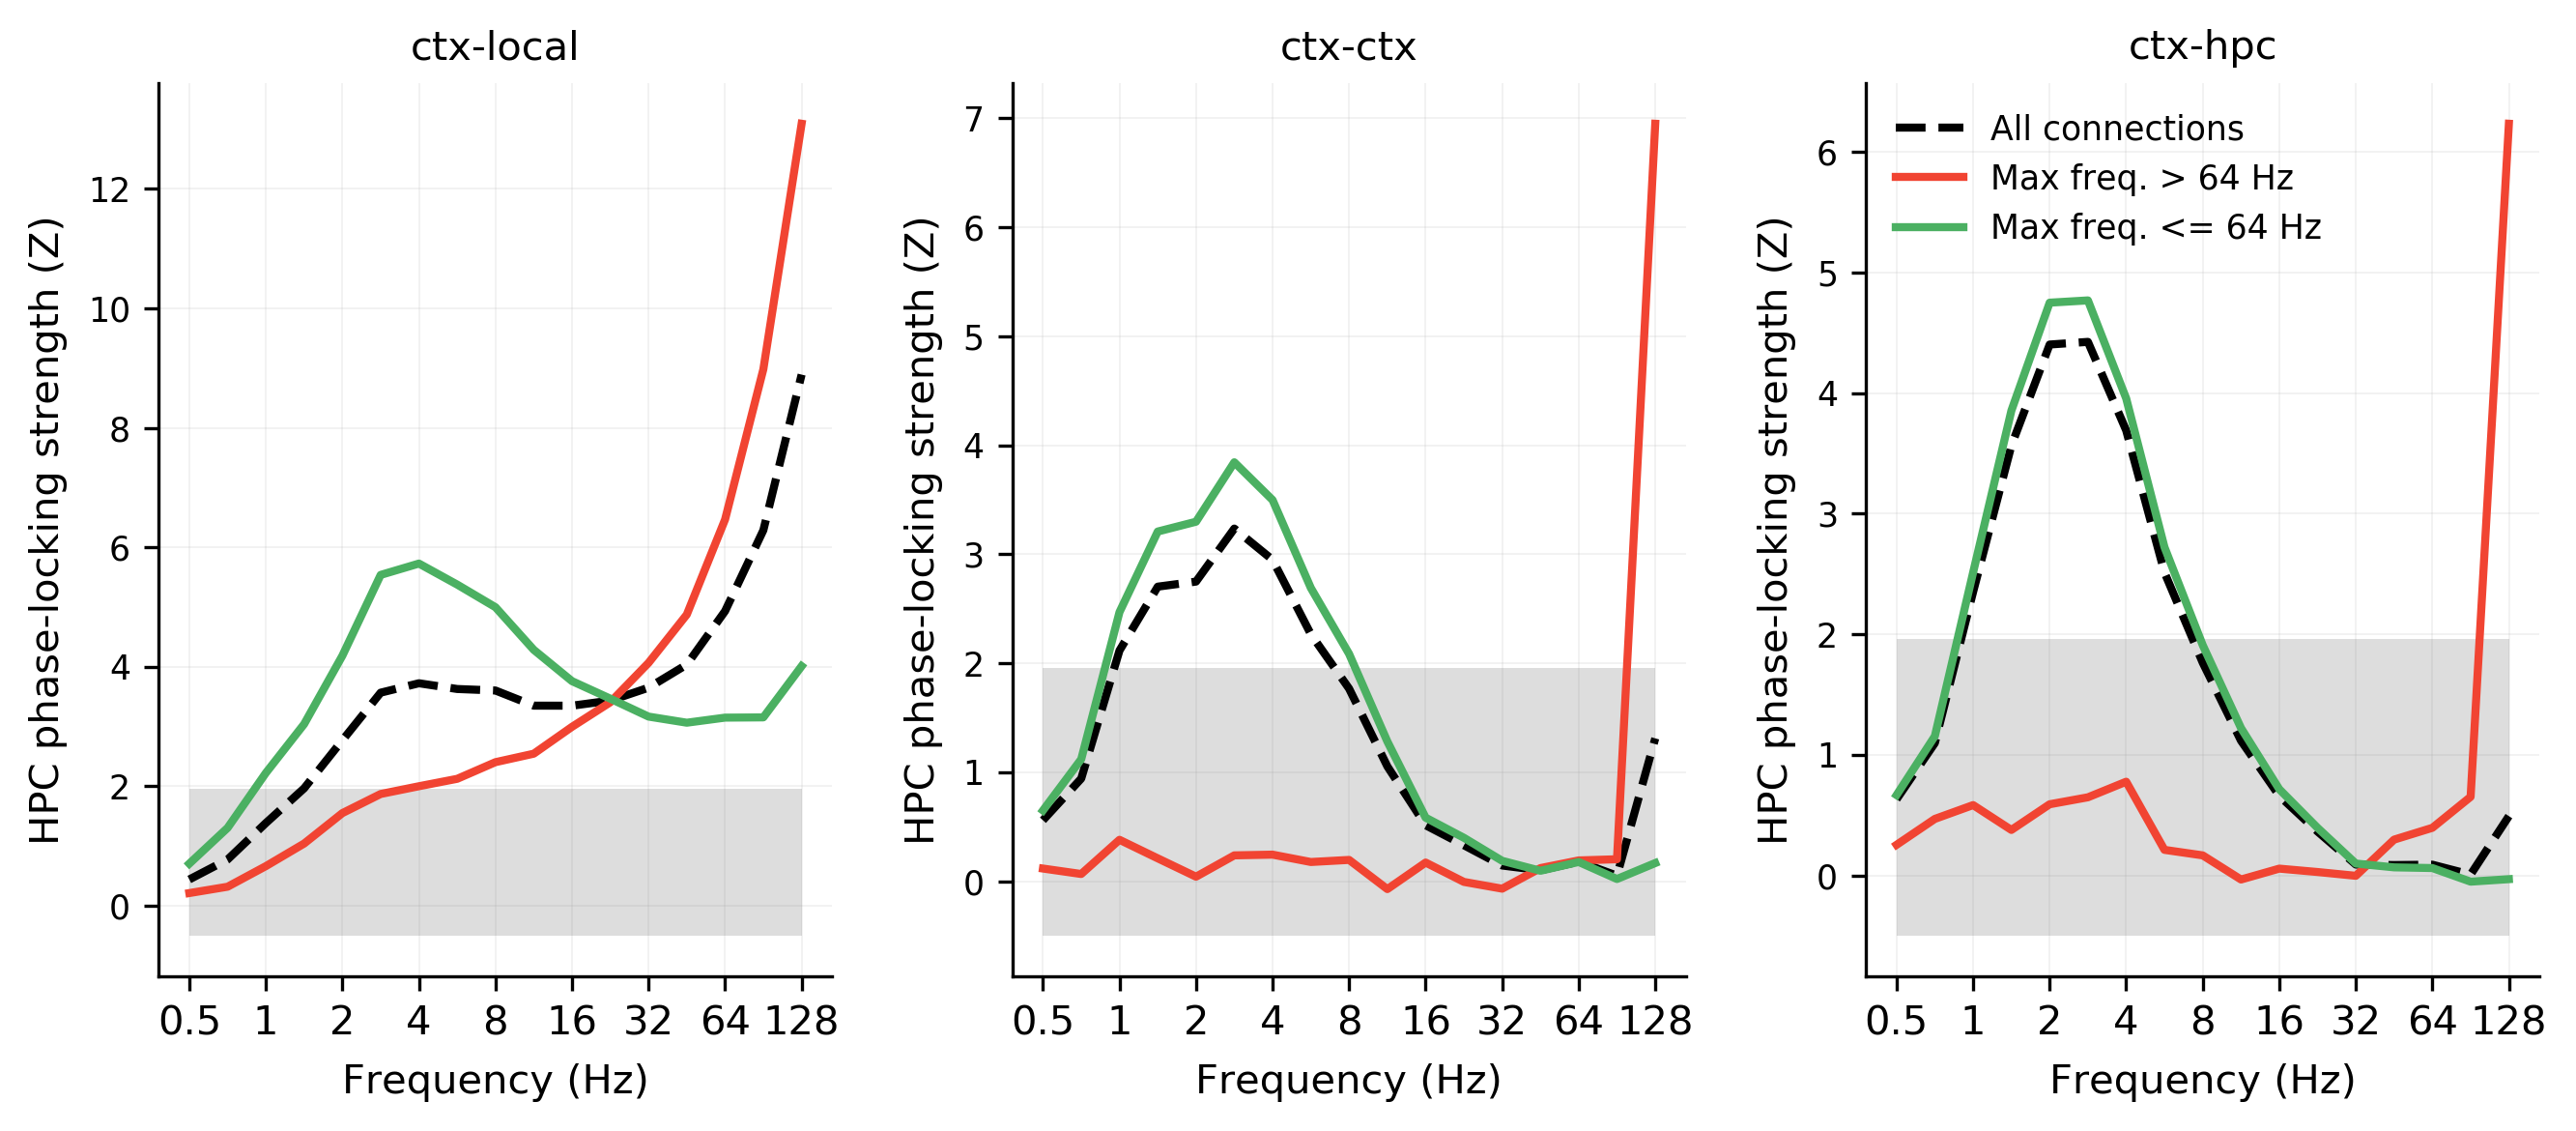

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
for i, edge_type in enumerate(['ctx-local', 'ctx-ctx', 'ctx-hpc']):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).mrls_z.tolist(), axis=0), 
               color='k', linestyle='--', linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z>14)".format(edge_type)).mrls_z.tolist(), axis=0), 
               color=colors[1], linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z<=14)".format(edge_type)).mrls_z.tolist(), axis=0), 
               color=colors[2], linewidth=2)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

custom_lines = [Line2D([0], [0], linewidth=2, linestyle='--', color='k', label='All connections'),
                Line2D([0], [0], linewidth=2, color=colors[1], label='Max freq. > 64 Hz'),
                Line2D([0], [0], linewidth=2, color=colors[2], label='Max freq. <= 64 Hz')]
legend = ax[2].legend(handles=custom_lines, loc=2)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

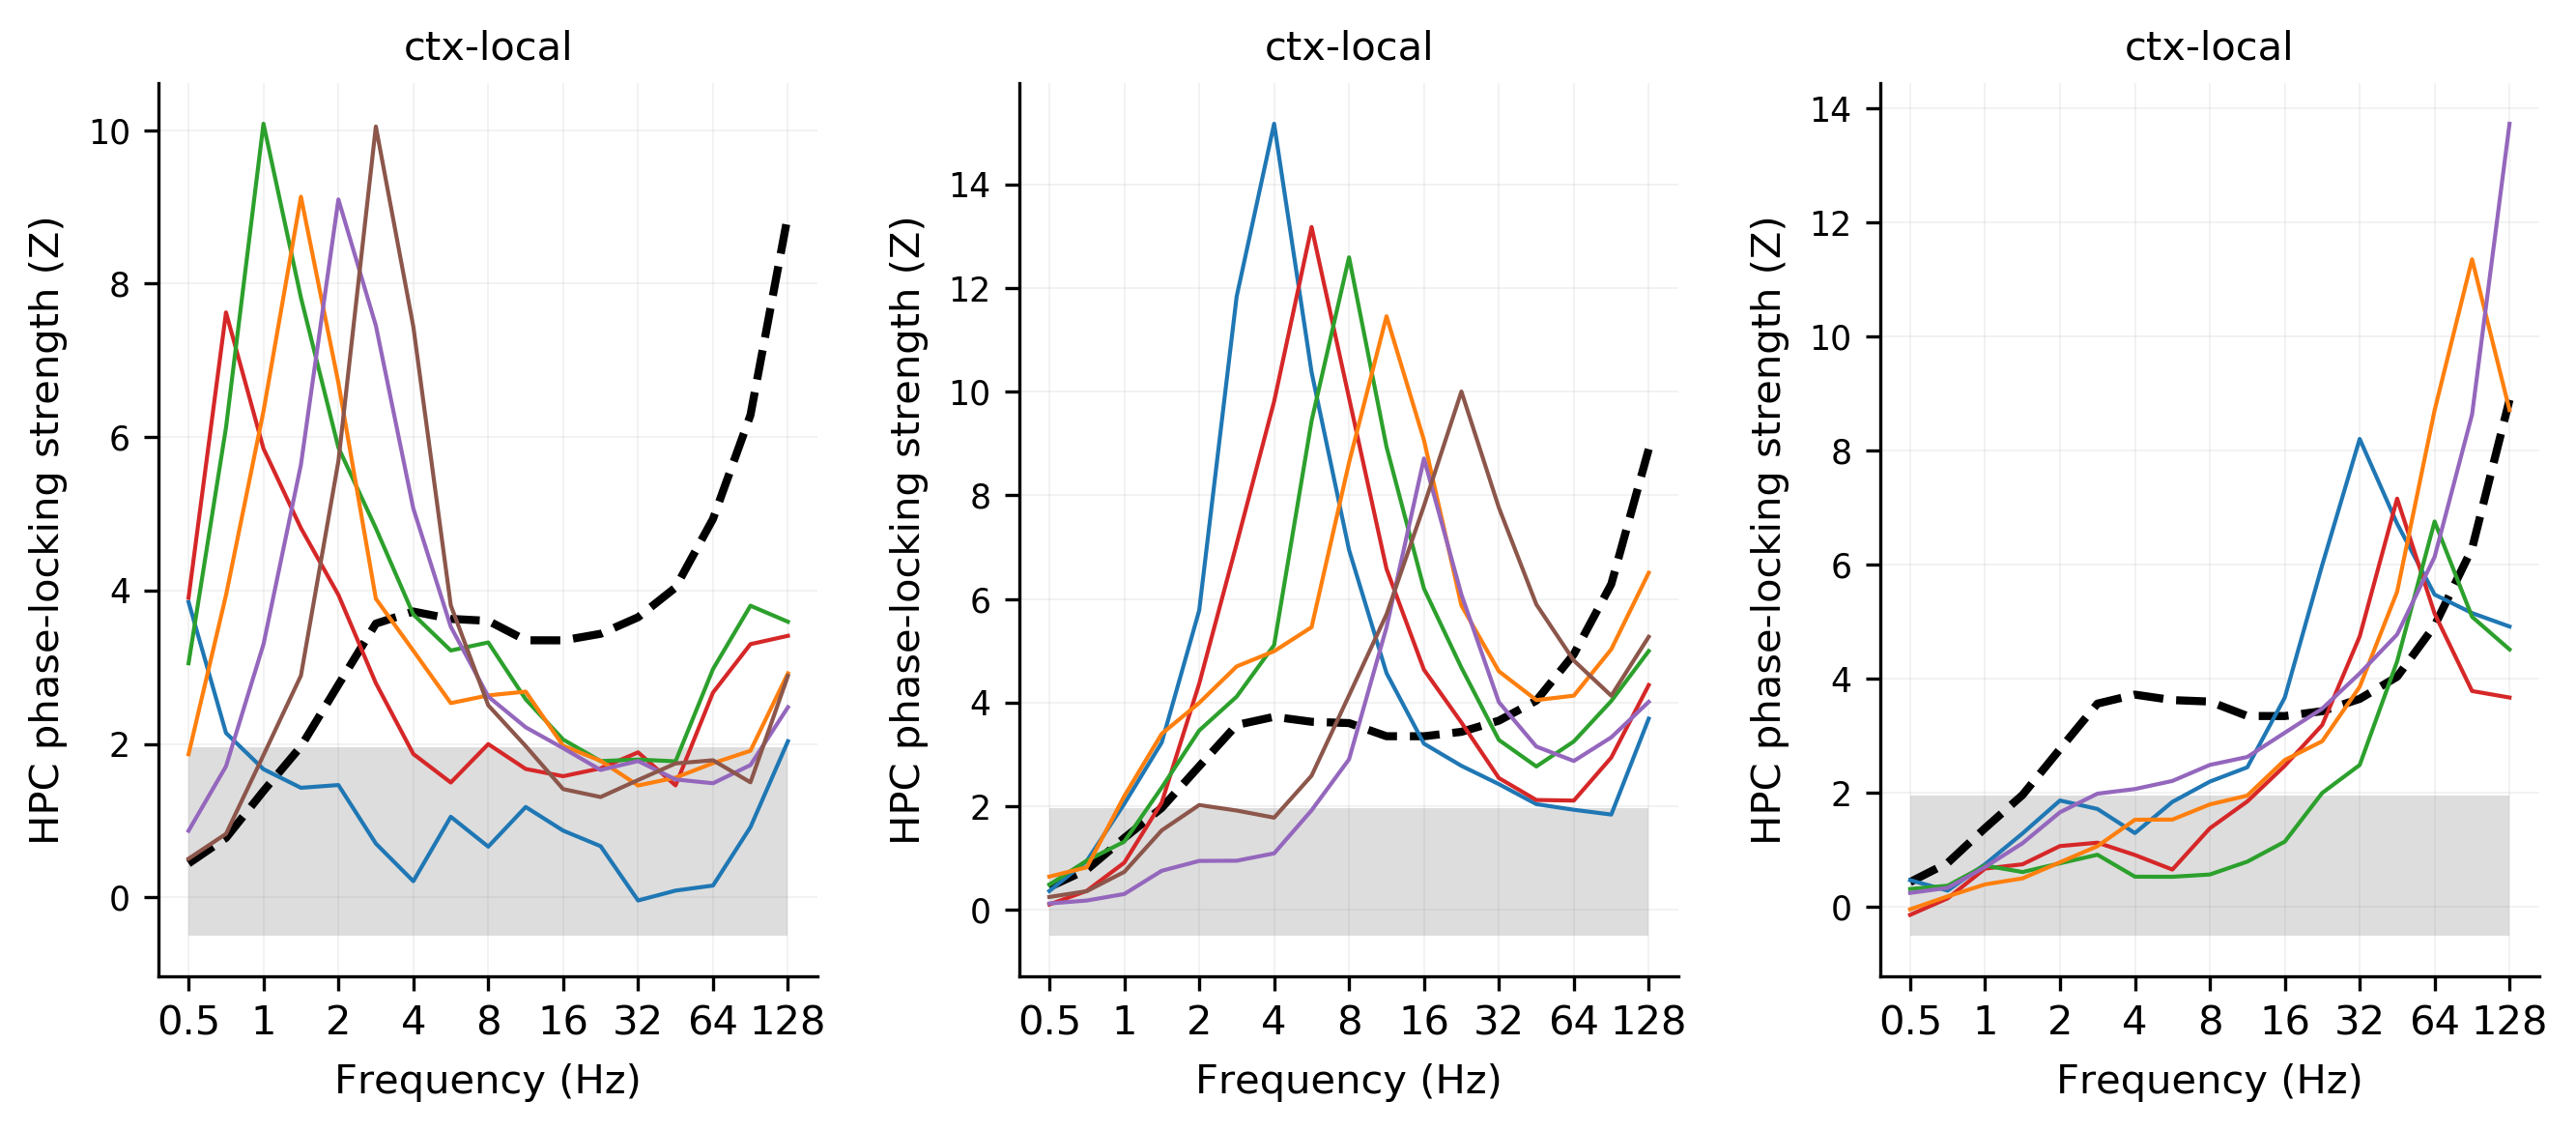

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
edge_type = 'ctx-local'
num_sets = [(0, 1, 2, 3, 4, 5), (6, 7, 8, 9, 10, 11), (12, 13, 14, 15, 16)]
for i, nums in enumerate(num_sets):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).mrls_z.tolist(), axis=0), 
               color='k', linestyle='--', linewidth=2)
    for num in nums:
        ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z=={})".format(edge_type, num)).mrls_z.tolist(), axis=0), 
                   linewidth=1)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


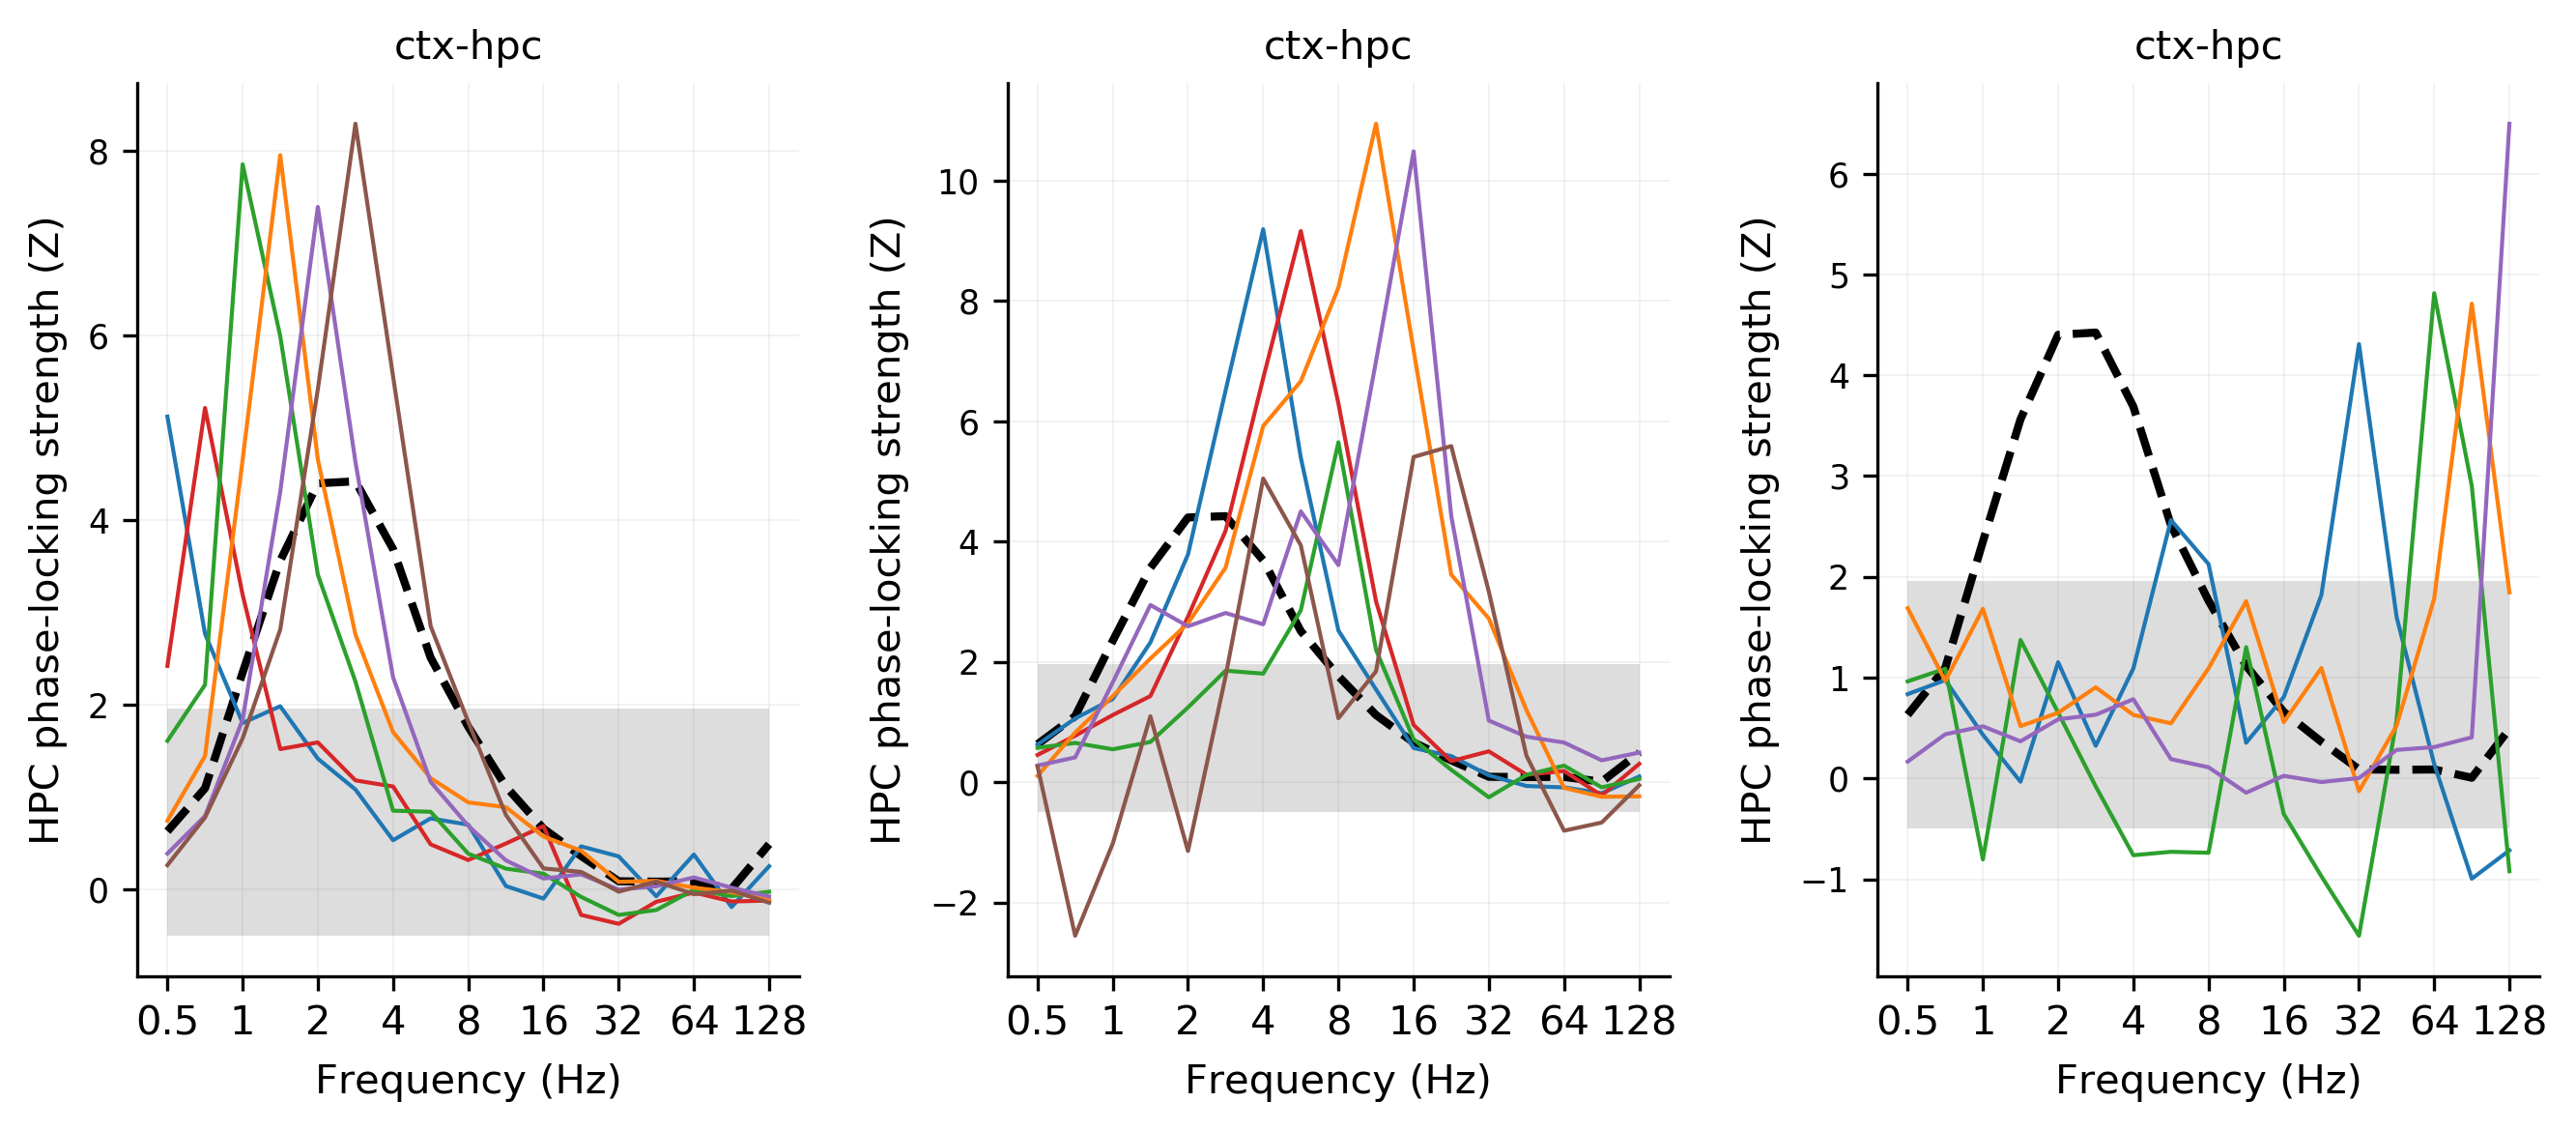

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
edge_type = 'ctx-hpc'
num_sets = [(0, 1, 2, 3, 4, 5), (6, 7, 8, 9, 10, 11), (12, 13, 14, 15, 16)]
for i, nums in enumerate(num_sets):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).mrls_z.tolist(), axis=0), 
               color='k', linestyle='--', linewidth=2)
    for num in nums:
        ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (locked_freq_ind_z=={})".format(edge_type, num)).mrls_z.tolist(), axis=0), 
                   linewidth=1)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

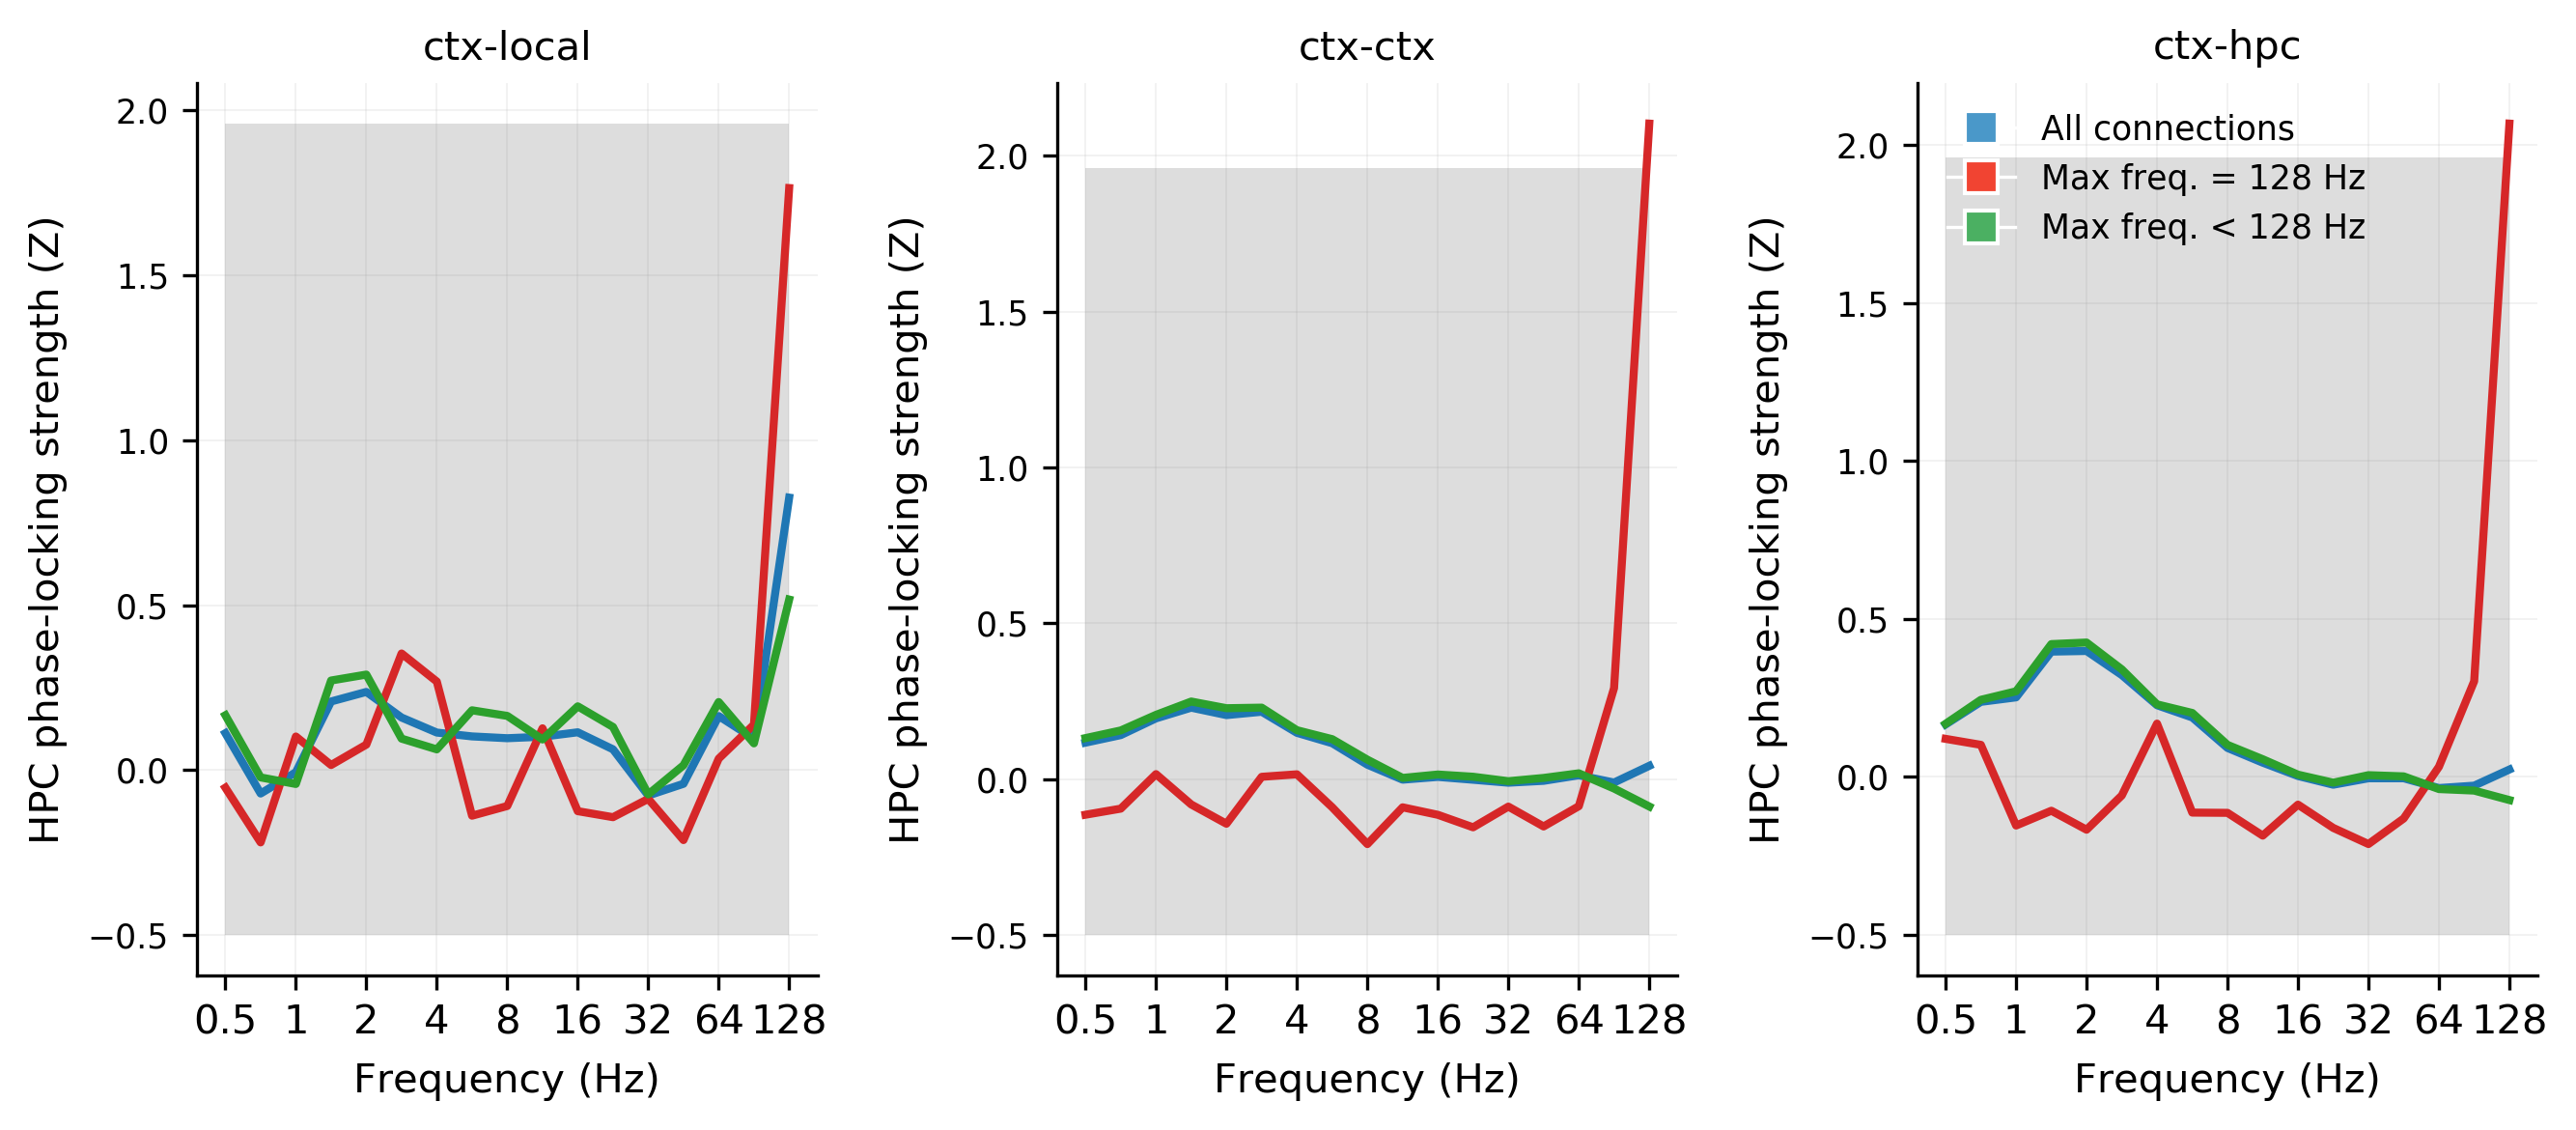

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
for i, edge_type in enumerate(['ctx-local', 'ctx-ctx', 'ctx-hpc']):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==False)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==False) & (locked_freq_ind_z==16)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==False) & (locked_freq_ind_z<16)".format(edge_type)).mrls_z.tolist(), axis=0), linewidth=2)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='All connections', markerfacecolor=colors[0], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Max freq. = 128 Hz', markerfacecolor=colors[1], markersize=8),
                Line2D([0], [0], marker='s', color='w', label='Max freq. < 128 Hz', markerfacecolor=colors[2], markersize=8)]
legend = ax[2].legend(handles=custom_lines, loc=2)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

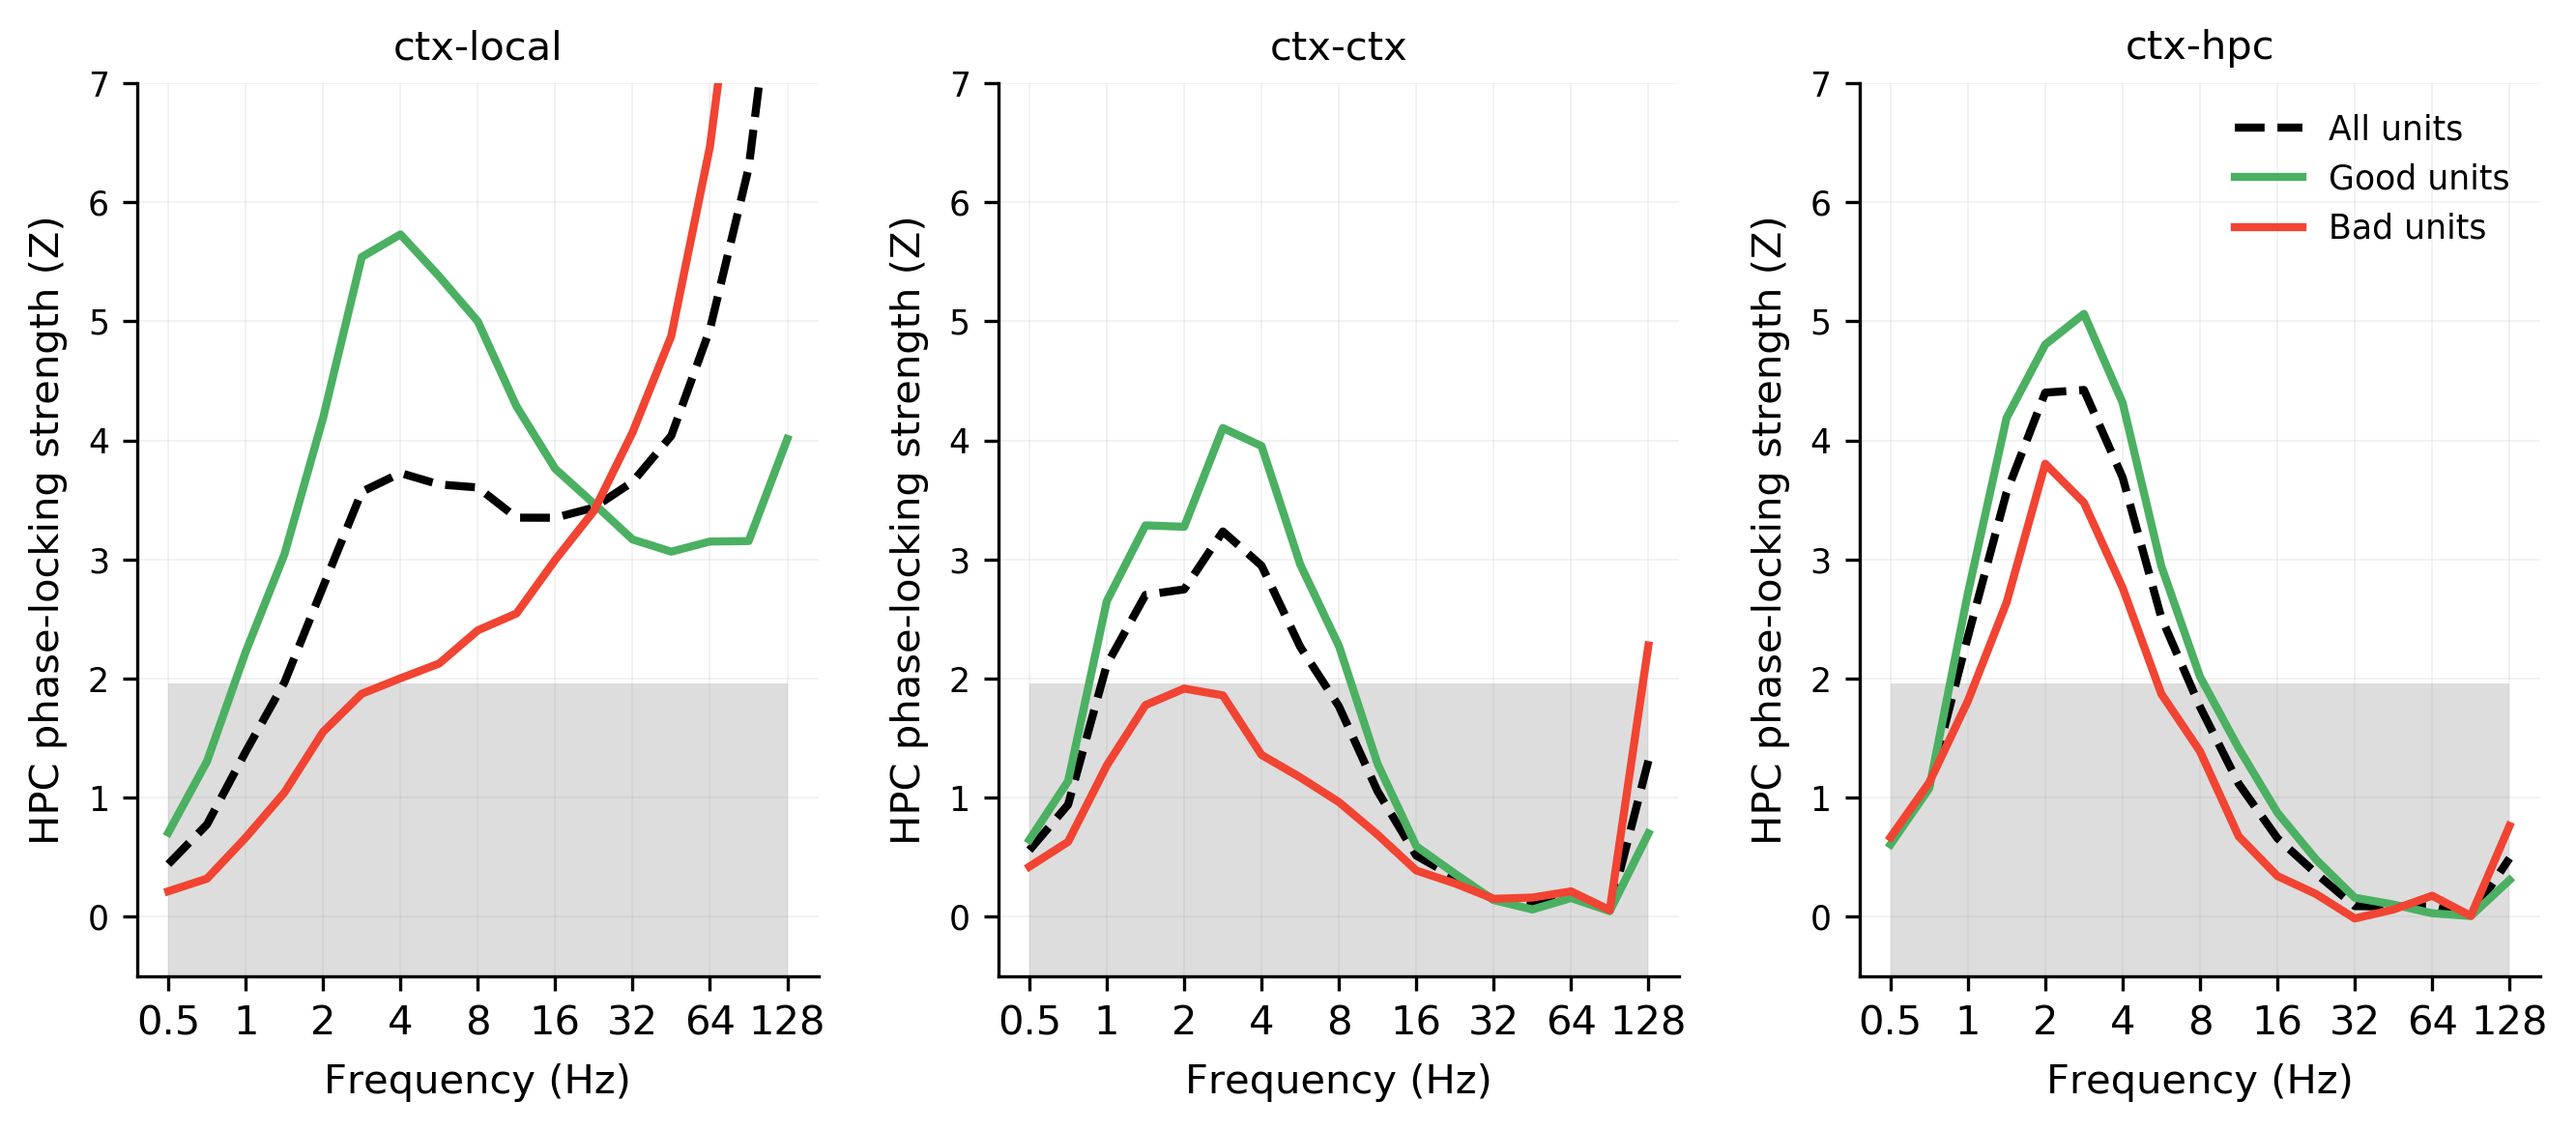

In [160]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
for i, edge_type in enumerate(['ctx-local', 'ctx-ctx', 'ctx-hpc']):
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).mrls_z.tolist(), axis=0), 
               color='k', linewidth=2, linestyle='--')
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (subj_sess_unit!={})".format(edge_type, bad_units)).mrls_z.tolist(), axis=0), 
               color=colors[2], linewidth=2)
    ax[i].plot(np.mean(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (subj_sess_unit=={})".format(edge_type, bad_units)).mrls_z.tolist(), axis=0), 
               color=colors[1], linewidth=2)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylim([-0.5, 7])
    ax[i].set_ylabel('HPC phase-locking strength (Z)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

custom_lines = [Line2D([0], [0], linewidth=2, color='k', linestyle='--', label='All units'),
                Line2D([0], [0], linewidth=2, color=colors[2], label='Good units'),
                Line2D([0], [0], linewidth=2, color=colors[1], label='Bad units')]
legend = ax[2].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

In [148]:
#bad_units = pl_df.query("(edge=='ctx-local') & (locked_freq_ind_z>14) & (sig_z_fdr==True)").subj_sess_unit.tolist()
bad_units = list(np.unique(pl_df.query("(edge=='ctx-local') & (locked_freq_ind_z>14)").subj_sess_unit.tolist()))

In [149]:
pl_df['bad_unit'] = False
pl_df.loc[pl_df.subj_sess_unit.isin(bad_units), 'bad_unit'] = True

In [150]:
pl_df.groupby(['edge', 'bad_unit', 'same_hem']).agg({'unit': len, 'sig': np.mean, 'sig_z_fdr': np.mean})

unit       sig  sig_z_fdr
edge      bad_unit same_hem                           
ctx-ctx   False    False     1490  0.130201   0.106711
                   True      1712  0.211449   0.174650
          True     False     1829  0.117004   0.075451
                   True      1656  0.129227   0.091184
ctx-hpc   False    False      600  0.235000   0.215000
                   True       688  0.366279   0.363372
          True     False      640  0.170313   0.148438
                   True       679  0.243004   0.237113
ctx-local False    True       650  0.698462   0.881538
          True     True       698  0.873926   0.954155
hpc-ctx   False    False      876  0.158676   0.138128
                   True       961  0.319459   0.296566
hpc-hpc   False    False      322  0.366460   0.385093
                   True        57  0.456140   0.578947
hpc-local False    True       328  0.832317   0.969512

In [41]:
np.array([2**((i/2) - 1) for i in range(16)])

array([ 0.5       ,  0.70710678,  1.        ,  1.41421356,  2.        ,
        2.82842712,  4.        ,  5.65685425,  8.        , 11.3137085 ,
       16.        , 22.627417  , 32.        , 45.254834  , 64.        ,
       90.50966799])

In [32]:
freqs

array([  0.5       ,   0.70710678,   1.        ,   1.41421356,
         2.        ,   2.82842712,   4.        ,   5.65685425,
         8.        ,  11.3137085 ,  16.        ,  22.627417  ,
        32.        ,  45.254834  ,  64.        ,  90.50966799,
       128.        ])

In [124]:
np.arange(len(freqs)).shape

(17,)

In [133]:
np.histogram(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).locked_freq_ind_z.tolist(), bins=np.arange(len(freqs)+1))

(array([  7,  15,  45,  85, 144, 112,  88,  27,  32,   9,  13,   1,   3,
          0,   1,   3,  50]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]))

In [142]:
np.sum(np.array(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).locked_freq_ind_z.tolist())==13)

0

In [143]:
def get_counts(v, keys=np.arange(17)):
    v = np.array(v)
    vals = []
    for key in keys:
        vals.append(np.sum(v==key))
    vals = np.array(vals)
    return keys, vals

In [155]:
#pl_df.query("(edge=='ctx-local') & (sig_z_fdr==True)").locked_freq_ind_z.tolist()

In [156]:
edge_type = 'ctx-local'
get_counts(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (subj_sess_unit=={})".format(edge_type, bad_units)).locked_freq_ind_z.tolist())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  85, 581]))

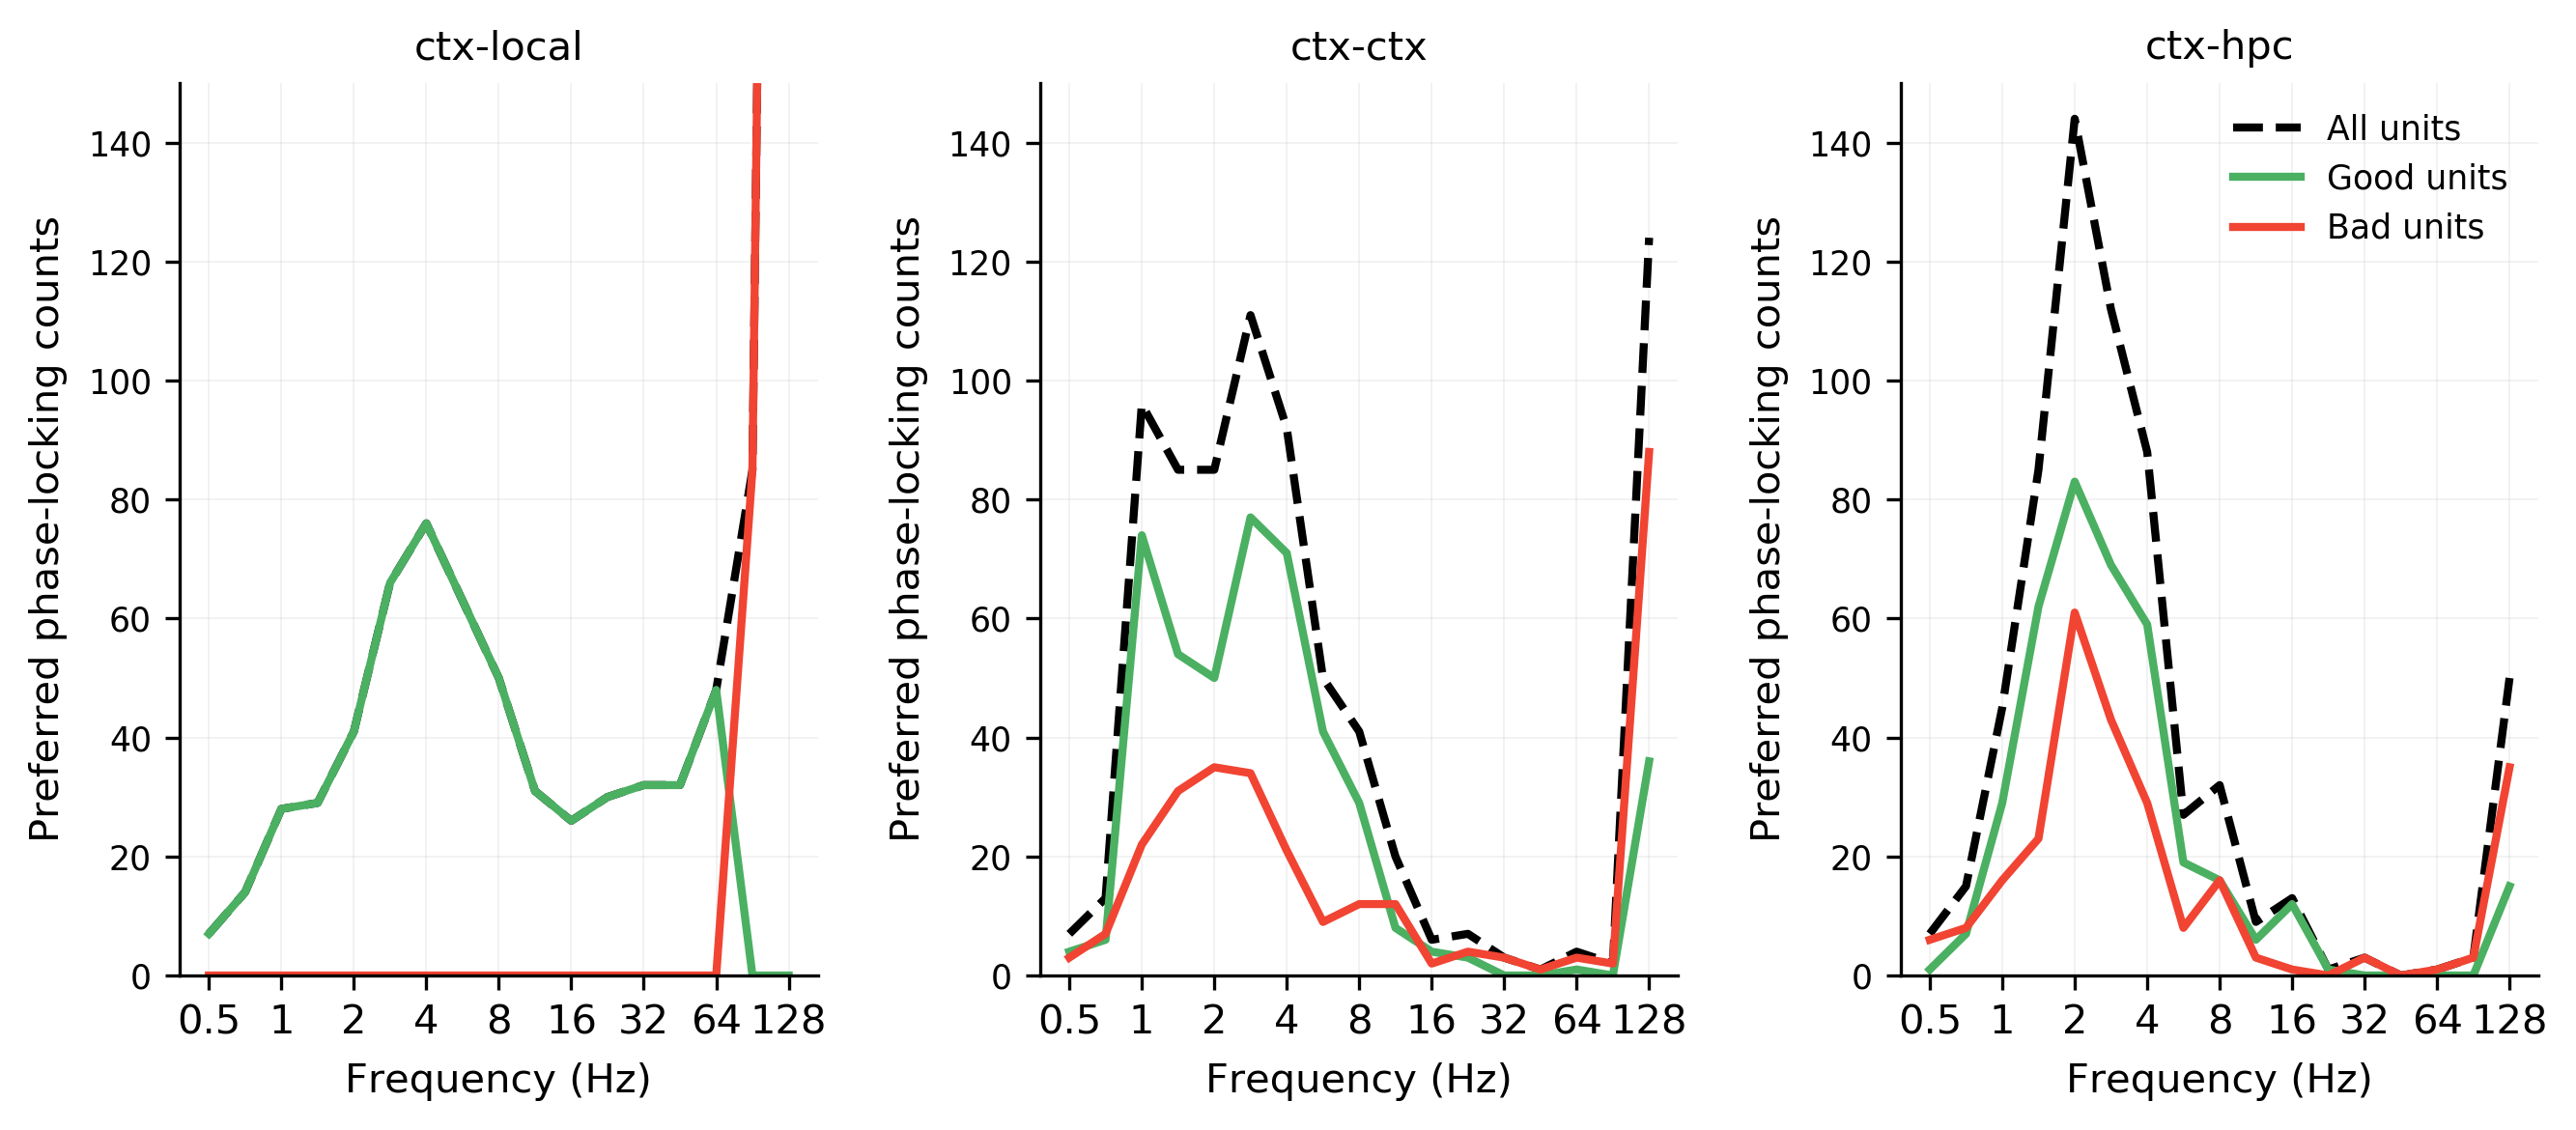

In [161]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), dpi=300)
ax = np.ravel(ax)

i = 0
for i, edge_type in enumerate(['ctx-local', 'ctx-ctx', 'ctx-hpc']):
    ax[i].plot(get_counts(pl_df.query("(edge=='{}') & (sig_z_fdr==True)".format(edge_type)).locked_freq_ind_z.tolist())[1], 
               color='k', linewidth=2, linestyle='--')
    ax[i].plot(get_counts(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (subj_sess_unit!={})".format(edge_type, bad_units)).locked_freq_ind_z.tolist())[1], 
               color=colors[2], linewidth=2)
    ax[i].plot(get_counts(pl_df.query("(edge=='{}') & (sig_z_fdr==True) & (subj_sess_unit=={})".format(edge_type, bad_units)).locked_freq_ind_z.tolist())[1], 
               color=colors[1], linewidth=2)
    ax[i].set_xticks(np.arange(len(freqs))[::2])
    ax[i].set_xticklabels([0.5, 1, 2, 4, 8, 16, 32, 64, 128], fontsize=tickfontsize)
    ax[i].set_xlabel('Frequency (Hz)', fontsize=labelfontsize, labelpad=5)
    ax[i].set_ylim([0, 150])
    ax[i].set_ylabel('Preferred phase-locking counts', fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(edge_type, fontsize=labelfontsize)
    #ax[i].fill_between(np.arange(len(freqs)), -0.5, 1.96, color=colors[-1], alpha=0.25, linewidth=0)

custom_lines = [Line2D([0], [0], linewidth=2, color='k', linestyle='--', label='All units'),
                Line2D([0], [0], linewidth=2, color=colors[2], label='Good units'),
                Line2D([0], [0], linewidth=2, color=colors[1], label='Bad units')]
legend = ax[2].legend(handles=custom_lines, loc=1)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])